# Case Study 3 workout (continued)
The actual coding of the optimization

### Repeat of code from previous notebook.
`2000.22.Nov.19`

In [1]:
# Run the code written in notebook 02
%run 'baker-cs34-functions.py'

In [2]:
#- Rip the boundary coordinates from the .yaml file -#
fn = "iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)
coordList = closeBndryList(bndryPts)    # Duplicate the first coordinate for a closed boundary
#print(bndryPts)

## Interpolating and visualizing the grids
`1549.05.Dec.19`

This time we need to save the formulas created.

I'm having difficulty finding how to make an `np.recarray()` of the correct `interp1d` data type, so I can initialize an empty array to hold the ones that are created.

Though I did figure out how to save all the helper functions in a separate file and use `%run` so they would be here referenced, instead of copy/pasting the entire thing

FINALLY figured it out initializing the array with `np.empty(numSides, interp1d)` with is of `NoneType`
`1746.05.Dec.19`

In [3]:
#-- Plot the boundary (modelled with splines) --#
displaySize = np.recarray(1, coordinate)
displaySize.x = 10
displaySize.y = 10
numLinspace = 10
numGridLines = 10                   # How many gridlines we'll use for the visualization
clsdBP = closeBndryList(bndryPts)
vertexList = [0, 6, 8, 9, 18]       # Hard code the vertices (though this could be done algorithmically)
numSides = len(vertexList) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)

#-- Plot our space (with splines) --#
splineList = np.empty(numSides, interp1d)                  # Init. array IOT save the Splines for each "side"
segCoordList = np.recarray([numSides, numGridLines], coordinate)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides):
    BndPts = clsdBP[vertexList[i]:(vertexList[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList[i] = sliceBoundary(BndPts, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList[i] = interp1d(segCoordList[i].x, segCoordList[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>
    

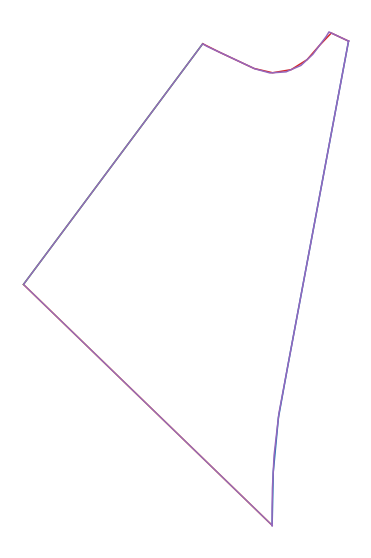

In [4]:
#- Plot the splines over the origianl coordinate list -#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize)
    
printBoundary(coordList,displaySize)

### Aside (thoughts on gridding)
`1841.05.Dec.19`

Now I have to figure out how to grid it so it contours properly. Eduardo attempted this with a creative method, but I don't think it's completly accurate. The figure from his earlier referenced jupyter notebook is here included:
<img src="figures/eduardo-grid.png" alt="cs3 boundary with example turbine placement" width="800"/>
As one can see, the center is quite strictly gridded, and the outtermost grid isn't contoured quite correctly. I'll have to figure out how to meld this a bit "better"

Drawing it out on the markerboard, I want it to look like this:

<img src="figures/translation.jpg" alt="cs3 boundary with example turbine placement" width="800"/>

Where the right grid is the Euclidean space, and the left object is the projected translation space. NOte that coordinates are normalized between zero and one.

Also I just figured out how to properly insert an image into a Jupyter Notebook. `1816.05.Dec.19`

## Interpolating and visualizing the grids (continued)
`1843.05.Dec.19`

### Gridding the Euclidean space
`1843.05.Dec.19`

First I'll need to sub-divide each splined side into say 30 points along each line, then plot all interpolated "grid lines" using those points as vertices.

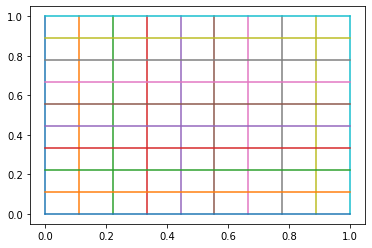

In [5]:
#-- Create and plot the Euclidean space (normalized from 0 to 1) --#
vertLineArrayEuc = np.recarray([numGridLines,numLinspace], coordinate)
horizLineArrayEuc = np.recarray([numGridLines,numLinspace], coordinate)

xVertGridValsEuc = np.linspace(0, 1, numGridLines, endpoint=True)
yHorizGridValsEuc = np.linspace(0, 1, numGridLines, endpoint=True)
gridLinspace = np.linspace(0, 1, numLinspace, endpoint=True)

# Get our vertical lines
for i in range(numGridLines):        # Loop through all x-values
    for k in range(numLinspace):        # Loop through all y-values in our linspace
        vertLineArrayEuc[i][k].x = xVertGridValsEuc[i]
        vertLineArrayEuc[i][k].y = gridLinspace[k]
    plt.plot(vertLineArrayEuc[i].x,vertLineArrayEuc[i].y)

# Get our horizontal lines
for j in range(numGridLines):           # Loop through all y-values
    for i in range(numLinspace):        # Loop through all x-values in our linspace
        horizLineArrayEuc[j][i].x = gridLinspace[i]
        horizLineArrayEuc[j][i].y = yHorizGridValsEuc[j]
    plt.plot(horizLineArrayEuc[j].x,horizLineArrayEuc[j].y)        

### Making divisions along the splines
`1957.05.Dec.19`<br/>
Now that I've got the euclidean grid lines sorted, I've got to figure out how to project them onto the new boundaries.<br/>
First I'll just make the right endpoints on the spline boundaries.

I've got a problem where I added a point to the end, so instead of 5 there are 6 points. I'll have to sort it out after I get it working.

That was actually a relatively simple fix in the source code.`2108.5.Dec.19`

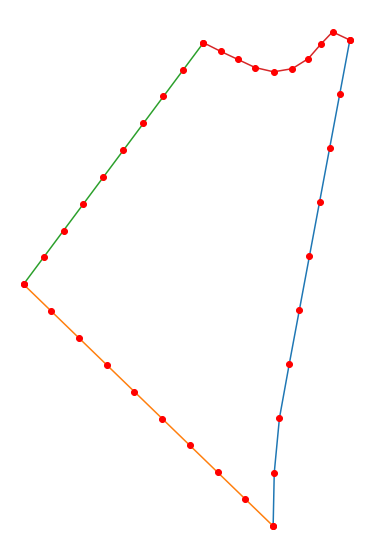

In [6]:
#- Plot the splines with grid vertices along the splines -#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize)
    printVerticies(segCoordList[i], list(range(numGridLines)), 'red')

Now that I figured out how to divide the boundary lines correctly, I have to trace the grid lines.

### Link the vertices
`2114.05.Dec.19`<br/>
I'll start with just the vertical grid lines.<br/>
I'll use splines [0] and [2] map to the horizontal euclidean boundaries, and [1] and [4] map to the vertical euclidean boundaries

I think (for the vertical gridlines) the x-values need to be averages of the corresponding spot on the side boundaries. The y-values need to be averages of the corresponding spots on the top and bottom boundaries.

`0021.06.Dec.19`<br/>
So I just spent quite a few hours trying to figure that out, and unfortunately that algorithm doesn't work. For concavities it results in grids that fall outside the boundary. I'll have to think on Eduardo's method and how to adapt it.

`0047.06.Dec.19`<br/>
I think I solved it, but am investigating that I actually used the splines, and not the original recutting of the descretized lines.

In [7]:
# Startup stuff
# Get our vertical lines (in the translated space)
vertLineArrayTrs = np.recarray([numGridLines,numLinspace], coordinate)
horizLineArrayTrs = np.recarray([numLinspace, numGridLines], coordinate)

# Make our endpoint arrays
rgt = 0
btm = 1
lft = 2
top = 3

# Invert the list so it's not counter-clockwise
segCoordList[btm] = segCoordList[btm][::-1]
segCoordList[rgt] = segCoordList[rgt][::-1]

In [8]:
#-- Do just straight lines (as a test) --#
# Plot the boundary and the endpoints.
#for i in range(numSides):
#    plt.hold = True
#    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize)
#for i in range(numGridLines):
#    for j in range(numLinspace):
#        vertLineArrayTrs[i][j].y = (segCoordList[top][i].y - segCoordList[btm][i].y)* gridLinspace[j] + segCoordList[btm][i].y
#        vertLineArrayTrs[i][j].x = (segCoordList[top][i].x - segCoordList[btm][i].x)* gridLinspace[j] + segCoordList[btm][i].x
#    plt.plot(vertLineArrayTrs[i].x, vertLineArrayTrs[i].y)
#-- end test --#

In [9]:
#- Plot the splines with grid vertices along the splines -#
#for i in range(numSides):
#    plt.hold = True
#    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize)
#    printVerticies(segCoordList[i], list(range(numGridLines)), 'red')
#    plt.plot(topGridBnds[11].x, splineList[top](topGridBnds[11].x), 'x')

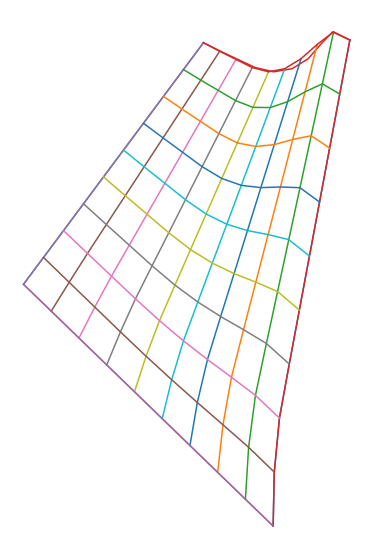

In [10]:
# Plot the boundary and the endpoints.
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize)
#    printBoundaryArray(segCoordList[i].x, segCoordList[i].y, displaySize)
#printVerticies(topGridBnds, list(range(numGridLines)), 'red')
#printVerticies(btmGridBnds, list(range(numGridLines)), 'red')
#printVerticies(lftGridBnds, list(range(numGridLines)), 'red')
#printVerticies(rgtGridBnds, list(range(numGridLines)), 'red')
#plt.plot(segCoordList[top][j].x, splineList[top](segCoordList[top][j].x), 'x')

# Do the vertical lines
yStartCoord = splineList[btm](segCoordList[btm].x)
yEndCoord = splineList[top](segCoordList[top].x)
for i in range(numGridLines):
    for j in range(numLinspace):
        vertLineArrayTrs[i][j].y = ((yEndCoord[i] - yStartCoord[i]) * gridLinspace[j]) + yStartCoord[i]
        xEndCoord = segCoordList[rgt][j].x
        xStartCoord = segCoordList[lft][j].x
        vertLineArrayTrs[i][j].x = ((xEndCoord - xStartCoord) * gridLinspace[i]) + xStartCoord
    plt.plot(vertLineArrayTrs[i].x, vertLineArrayTrs[i].y)
    
# Do the horizontal lines
for i in range(numLinspace):
    xStartCoord = segCoordList[lft][i].x
    xEndCoord = segCoordList[rgt][i].x
    for j in range(numGridLines):
        horizLineArrayTrs[i][j].x = ((xEndCoord - xStartCoord) * gridLinspace[j]) + xStartCoord
        yEndCoord = splineList[top](segCoordList[top][j].x)
        yStartCoord = splineList[btm](segCoordList[btm][j].x)
        horizLineArrayTrs[i][j].y = ((yEndCoord - yStartCoord) * gridLinspace[i]) + yStartCoord
    plt.plot(horizLineArrayTrs[i].x, horizLineArrayTrs[i].y)

`0111.06.Dec.19`<br/>
I'm very close, but still not quite there. You can see that in the top portion my grid goes out of bounds.

`0320.06.Dec.19`<br/>
The problem is that the x-values aren't evenly distributed like a linspace. It's gotta be determined from walking the perimeter, as I do in `sliceBoundary()`. From this, I need to get the x-distribution (percentage between each `x`, it'll be irregular). From THAT I can get the right spacing. But I'll need to somehow average the spacing between the top and the bottom.  I'll try again below, copying the above cell as a start point.

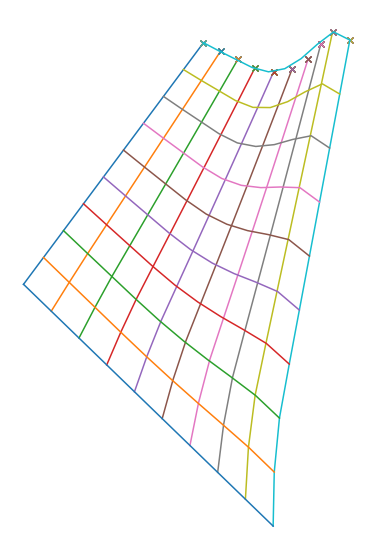

In [38]:
# Plot the boundary and the endpoints.
for i in range(numSides):
    plt.hold = True
#    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize)
#plt.axis('scaled')                      # Trim the white space
#plt.axis('off')                         # Turn off the framing
#plt.gcf().set_size_inches(displaySize.x, displaySize.y)   # Make it big and readable
#    printBoundaryArray(segCoordList[i].x, segCoordList[i].y, displaySize)
#printVerticies(topGridBnds, list(range(numGridLines)), 'red')
#printVerticies(btmGridBnds, list(range(numGridLines)), 'red')
#printVerticies(lftGridBnds, list(range(numGridLines)), 'red')
#printVerticies(rgtGridBnds, list(range(numGridLines)), 'red')
#plt.plot(segCoordList[top][j].x, splineList[top](segCoordList[top][j].x), 'x')
perimDist = np.empty([numSides, len(segCoordList[top])], np.float64)# This will hold our percentages
weightTermEW = np.linspace(0, 1, numLinspace, endpoint=True)
weightTermNS = np.linspace(0, 1, numGridLines, endpoint=True)
#Denom = np.recarray(len(segCoordList), np.float64)

# x-distribution weight for our top and btm boundaries
topDenom = segCoordList[top][len(segCoordList[top])-1].x - segCoordList[top][0].x
btmDenom = segCoordList[btm][len(segCoordList[btm])-1].x - segCoordList[btm][0].x
for j in range(numLinspace):
    topNum = segCoordList[top][j].x - segCoordList[top][0].x
    btmNum = segCoordList[btm][j].x - segCoordList[btm][0].x
    perimDist[top][j] = (topNum / topDenom)   # Get the percentage along the path
    perimDist[btm][j] = (btmNum / btmDenom)   # Get the percentage along the path

# Do the vertical lines
yStartCoord = splineList[btm](segCoordList[btm].x)
yEndCoord = splineList[top](segCoordList[top].x)
for i in range(numGridLines):
    for j in range(numLinspace):
        vertLineArrayTrs[i][j].y = ((yEndCoord[i] - yStartCoord[i]) * gridLinspace[j]) + yStartCoord[i]
        xEndCoord = segCoordList[rgt][j].x
        xStartCoord = segCoordList[lft][j].x
        # "Where the magic happens" according to Eduardo
        weightTermEW[j] = (gridLinspace[j] * perimDist[top][i]) + ((1-gridLinspace[j]) * perimDist[btm][i])
        vertLineArrayTrs[i][j].x = ((xEndCoord - xStartCoord) * weightTermEW[j]) + xStartCoord
        plt.plot(segCoordList[top][j].x, splineList[top](segCoordList[top][j].x), 'x')
    plt.plot(vertLineArrayTrs[i].x, vertLineArrayTrs[i].y)
    plt.axis('scaled')                      # Trim the white space
    plt.axis('off')                         # Turn off the framing
    plt.gcf().set_size_inches(displaySize.x, displaySize.y)   # Make it big and readable
    
# x-distribution weight for our top and btm boundaries
rgtDenom = segCoordList[rgt][len(segCoordList[rgt])-1].x - segCoordList[rgt][0].x
lftDenom = segCoordList[lft][len(segCoordList[lft])-1].x - segCoordList[lft][0].x
for j in range(numGridLines):
    rgtNum = segCoordList[rgt][j].x - segCoordList[rgt][0].x
    lftNum = segCoordList[lft][j].x - segCoordList[lft][0].x
    perimDist[rgt][j] = (rgtNum / rgtDenom)   # Get the percentage along the path
    perimDist[lft][j] = (lftNum / lftDenom)   # Get the percentage along the path
# Do the horizontal lines
for i in range(numLinspace):
    xStartCoord = segCoordList[lft][i].x
    xEndCoord = segCoordList[rgt][i].x
    for j in range(numGridLines):
        horizLineArrayTrs[i][j].x = ((xEndCoord - xStartCoord) * gridLinspace[j]) + xStartCoord
        yEndCoord = splineList[top](segCoordList[top][j].x)
        yStartCoord = splineList[btm](segCoordList[btm][j].x)
        # "Where the magic happens" according to Eduardo
        weightTermNS[j] = (gridLinspace[j] * perimDist[lft][i]) + ((1-gridLinspace[j]) * perimDist[lft][i])
        horizLineArrayTrs[i][j].y = ((yEndCoord - yStartCoord) * weightTermNS[j]) + yStartCoord
    plt.plot(horizLineArrayTrs[i].x, horizLineArrayTrs[i].y)


Ok I think I'll try again from scratch. The problem isn't the splines (which are great), it's the x-values I'm using. I need to use `sliceBoundary()` to get the x-coordinate distribution along the arclength.

## Write the function generically
`0155.06.Dec.19`<br/>
Now that I know I can make contouring grids, I need to write a generic target function that, given the bounary splines, will return the transformed coordinate. This will be used for turbine location perturbations.

In [12]:
def giveTranslatedCoord(listFourSplines, coordEuc):
    # Given (4) splines in an irregular shape,
    # and the original Euclidean coordinates(normalized so (x,y) = ([0,1],[0,1])
    # This returns the Euclidean coordinate in the transformed space.

SyntaxError: unexpected EOF while parsing (<ipython-input-12-67d717ffafb1>, line 4)